This "Candidate Exercise" was completed by Sandy Graham on October 8, 2019. I then continued to work on it to add a clustering algorithm for question 4.

Assignment:

This dataset contains a provider-level summary of inpatient discharges, average charges, and average Medicare payments for the top 100 Diagnosis-Related Groups (DRGs).

filename: CMS_Medicare_OpenSource_Data.csv

1. Which types of DRGs ("DRG.Definition") account for most of the patient population across all facilities?

2. For each facility ("Provider.Name"), which DRGs form the largest portion of the patient population?

3. Calculate the average Medicare payments per DRG per facility.

4. Is there a way to group facilities in a logical way?

Please provide any code (in either Python or R) that you used.  If you have any figures you'd like to show (though not at all required), feel free to include them in a separate file or inline in a notebook/markdown.

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from IPython.display import display # display makes prints render HTML before outputting
                                    # so that the output looks like a pretty dataframe

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2, whiten
from sklearn import metrics
import math
from mpl_toolkits.mplot3d import Axes3D

# Modeling
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

# Though the following import is not directly being used, it is required
# for 3D projection to work
from mpl_toolkits.mplot3d import Axes3D

pd.options.display.float_format = '{:20,.2f}'.format

np.random.seed(5)

Read data into a dataframe.

In [2]:
df = pd.read_csv('CMS_Medicare_OpenSource_Data.txt')

# print a sample of the data.
df.sample(5)

DRG Definition  Provider Id  \
118705  482 - HIP & FEMUR PROCEDURES EXCEPT MAJOR JOIN...       390290   
72896                          305 - HYPERTENSION W/O MCC       340039   
54236   280 - ACUTE MYOCARDIAL INFARCTION, DISCHARGED ...       310014   
16774   177 - RESPIRATORY INFECTIONS & INFLAMMATIONS W...       500141   
103704  392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...       360013   

                        Provider Name         Provider Street Address  \
118705  HAHNEMANN UNIVERSITY HOSPITAL          230 NORTH BROAD STREET   
72896   IREDELL MEMORIAL HOSPITAL INC  557 BROOKDALE DR  P O BOX 1828   
54236      COOPER UNIVERSITY HOSPITAL                  1 COOPER PLAZA   
16774   ST FRANCIS COMMUNITY HOSPITAL          34515 9TH AVENUE SOUTH   
103704       WILSON MEMORIAL HOSPITAL        915 WEST MICHIGAN STREET   

       Provider City Provider State  Provider Zip Code  \
118705  PHILADELPHIA             PA              19102   
72896    STATESVILLE             NC              28677   
54236         CAMDEN             NJ               8103   
16774    FEDERAL WAY             WA              98003   
103704        SIDNEY             OH              45365   

       Hospital Referral Region Description   Total Discharges   \
118705                    PA - Philadelphia                  11   
72896                    NC - Winston-Salem                  17   
54236                           NJ - Camden                  36   
16774                          WA - Seattle                  11   
103704                          OH - Dayton                  27   

        Average Covered Charges   Average Total Payments   \
118705                $190217.09                $15539.72   
72896                  $13695.47                 $3562.00   
54236                 $105391.75                $18753.08   
16774                  $40113.54                $13230.90   
103704                 $10295.85                 $4207.29   

       Average Medicare Payments  
118705                 $14728.09  
72896                   $2393.88  
54236                  $18192.38  
16774                  $12722.18  
103704                  $3248.92

Check for null values.

In [3]:
df.isnull().sum()

DRG Definition                          0
Provider Id                             0
Provider Name                           0
Provider Street Address                 0
Provider City                           0
Provider State                          0
Provider Zip Code                       0
Hospital Referral Region Description    0
 Total Discharges                       0
 Average Covered Charges                0
 Average Total Payments                 0
Average Medicare Payments               0
dtype: int64

No null values so data is clean. Rename the columns for ease of use.

In [4]:
df.rename(columns={'DRG Definition': 'DRG', 
                   'Provider Id': 'Prov_Id', 
                   'Provider Name': 'Prov_Name', 
                   'Provider Street Address': 'Prov_Address', 
                   'Provider City': 'Prov_City',
                   'Provider State': 'Prov_State',
                   'Provider Zip Code': 'Prov_Zip',
                   'Hospital Referral Region Description': 'Hospital_Region',
                   ' Total Discharges ': 'Reg_Total_Discharges',
                   ' Average Covered Charges ': 'Reg_Avg_Covered_Chgs',
                   ' Average Total Payments ': 'Reg_Avg_Total_Pmts',
                   'Average Medicare Payments': 'Avg_Medicare_Pmts',
                  },
          inplace=True)

Peek at general information about the data.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 12 columns):
DRG                     163065 non-null object
Prov_Id                 163065 non-null int64
Prov_Name               163065 non-null object
Prov_Address            163065 non-null object
Prov_City               163065 non-null object
Prov_State              163065 non-null object
Prov_Zip                163065 non-null int64
Hospital_Region         163065 non-null object
Reg_Total_Discharges    163065 non-null int64
Reg_Avg_Covered_Chgs    163065 non-null object
Reg_Avg_Total_Pmts      163065 non-null object
Avg_Medicare_Pmts       163065 non-null object
dtypes: int64(3), object(9)
memory usage: 14.9+ MB


See what the data looks like now.

In [6]:
df[:3].T

0  \
DRG                   039 - EXTRACRANIAL PROCEDURES W/O CC/MCC   
Prov_Id                                                  10001   
Prov_Name                     SOUTHEAST ALABAMA MEDICAL CENTER   
Prov_Address                            1108 ROSS CLARK CIRCLE   
Prov_City                                               DOTHAN   
Prov_State                                                  AL   
Prov_Zip                                                 36301   
Hospital_Region                                    AL - Dothan   
Reg_Total_Discharges                                        91   
Reg_Avg_Covered_Chgs                                 $32963.07   
Reg_Avg_Total_Pmts                                    $5777.24   
Avg_Medicare_Pmts                                     $4763.73   

                                                             1  \
DRG                   039 - EXTRACRANIAL PROCEDURES W/O CC/MCC   
Prov_Id                                                  10005   
Prov_Name                        MARSHALL MEDICAL CENTER SOUTH   
Prov_Address                        2505 U S HIGHWAY 431 NORTH   
Prov_City                                                 BOAZ   
Prov_State                                                  AL   
Prov_Zip                                                 35957   
Hospital_Region                                AL - Birmingham   
Reg_Total_Discharges                                        14   
Reg_Avg_Covered_Chgs                                 $15131.85   
Reg_Avg_Total_Pmts                                    $5787.57   
Avg_Medicare_Pmts                                     $4976.71   

                                                             2  
DRG                   039 - EXTRACRANIAL PROCEDURES W/O CC/MCC  
Prov_Id                                                  10006  
Prov_Name                       ELIZA COFFEE MEMORIAL HOSPITAL  
Prov_Address                                205 MARENGO STREET  
Prov_City                                             FLORENCE  
Prov_State                                                  AL  
Prov_Zip                                                 35631  
Hospital_Region                                AL - Birmingham  
Reg_Total_Discharges                                        24  
Reg_Avg_Covered_Chgs                                 $37560.37  
Reg_Avg_Total_Pmts                                    $5434.95  
Avg_Medicare_Pmts                                     $4453.79

# 1. Which types of DRGs ("DRG.Definition") account for most of the patient population across all facilities?

We want the top of the patient population across all facilities, so need to count the Reg_Total_Discharges.

In [7]:
DRG_series = df.groupby(['DRG'])['Reg_Total_Discharges'].sum().sort_values(ascending=False)
DRG_df = pd.DataFrame(DRG_series).reset_index()
DRG_df.head()

DRG  Reg_Total_Discharges
0  470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...                427207
1  871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...                319072
2  392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...                244854
3                   292 - HEART FAILURE & SHOCK W CC                222038
4    690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC                206695

The question did not specify what percentage of cases are requested, so I will interpret most to mean 50% of all the data.

The rows are sorted by highest count. Find how many of the top rows of DRG Definitions values comprise 50% of the whole dataset.

In [8]:
DRG_df.Reg_Total_Discharges.sum()

6975318

Calculate what 50% of total sum is:

In [9]:
.5 * DRG_df.Reg_Total_Discharges.sum()

3487659.0

Create a dataframe with just the total discharge for each DRG sorted.

In [10]:
Top_DRG_df = DRG_df.sort_values('Reg_Total_Discharges',ascending=False)

In [11]:
Top_DRG_df.head(5)

DRG  Reg_Total_Discharges
0  470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...                427207
1  871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...                319072
2  392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...                244854
3                   292 - HEART FAILURE & SHOCK W CC                222038
4    690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC                206695

Calculate the cumulative sum of the total discharges.

In [12]:
DRG_df.sort_values('Reg_Total_Discharges',ascending=False).cumsum().head(5)

DRG Reg_Total_Discharges
0  470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...               427207
1  470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...               746279
2  470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...               991133
3  470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...              1213171
4  470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...              1419866

Add a column for the cumulative sum.

In [13]:
DRG_df['cumsum'] = DRG_df.sort_values('Reg_Total_Discharges',ascending=False).cumsum()['Reg_Total_Discharges']

Add a column for the cumulative percentage of the whole.

In [14]:
DRG_df['cum_perc'] = DRG_df['cumsum']/ DRG_df.Reg_Total_Discharges.sum()

Print the DRGs that account for 50% of the DRGs across all facilities.

In [24]:
DRG_df[DRG_df['cum_perc'] < .5]

DRG  Reg_Total_Discharges  \
0   470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...                427207   
1   871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...                319072   
2   392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...                244854   
3                    292 - HEART FAILURE & SHOCK W CC                222038   
4     690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC                206695   
5              194 - SIMPLE PNEUMONIA & PLEURISY W CC                198390   
6                   291 - HEART FAILURE & SHOCK W MCC                185599   
7   641 - MISC DISORDERS OF NUTRITION,METABOLISM,F...                153660   
8                            683 - RENAL FAILURE W CC                150444   
9   190 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W MCC                149677   
10   191 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W CC                148491   
11                           312 - SYNCOPE & COLLAPSE                141918   
12                           603 - CELLULITIS W/O MCC                140894   
13                         378 - G.I. HEMORRHAGE W CC                138678   
14                                   313 - CHEST PAIN                131079   
15            193 - SIMPLE PNEUMONIA & PLEURISY W MCC                127989   
16  287 - CIRCULATORY DISORDERS EXCEPT AMI, W CARD...                115920   
17  192 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W/...                114790   
18  310 - CARDIAC ARRHYTHMIA & CONDUCTION DISORDER...                113454   

     cumsum             cum_perc  
0    427207                 0.06  
1    746279                 0.11  
2    991133                 0.14  
3   1213171                 0.17  
4   1419866                 0.20  
5   1618256                 0.23  
6   1803855                 0.26  
7   1957515                 0.28  
8   2107959                 0.30  
9   2257636                 0.32  
10  2406127                 0.34  
11  2548045                 0.37  
12  2688939                 0.39  
13  2827617                 0.41  
14  2958696                 0.42  
15  3086685                 0.44  
16  3202605                 0.46  
17  3317395                 0.48  
18  3430849                 0.49

Let's print that as a pretty chart.

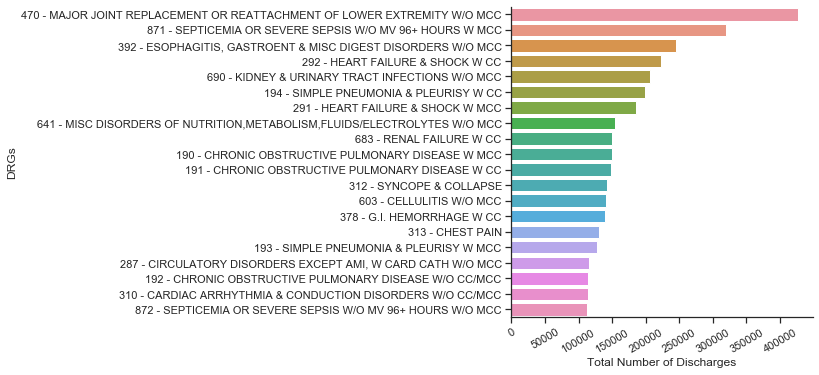

In [16]:
sns.set(style="ticks", color_codes=True)
graph = sns.catplot(x="Reg_Total_Discharges", y="DRG", kind="bar", data=DRG_df.head(20));
graph.set(xlabel='Total Number of Discharges', ylabel='DRGs')
graph.set_xticklabels(rotation=30)

# 2. For each facility ("Provider.Name"), which DRGs form the largest portion of the patient population?

Start by priming a list of the information for the first hospital. 

In [17]:
# For the SE AL Med Ctr, select three columns and sort by the # of discharges.
Reg_Tot_Discharges_df = df.loc[df['Prov_Name'] == 'SOUTHEAST ALABAMA MEDICAL CENTER', 
       ['Prov_Name', 'Reg_Total_Discharges', 'DRG']] \
  .sort_values(by='Reg_Total_Discharges', ascending=False)

# Then add a column for the cumulative sum of discharges.
Reg_Tot_Discharges_df['cumsum'] = Reg_Tot_Discharges_df['Reg_Total_Discharges'].cumsum()

# Now add a column for the percentage of all discharges at the hospital.
Reg_Tot_Discharges_df['Dischg_perc'] = Reg_Tot_Discharges_df['cumsum'] / Reg_Tot_Discharges_df['Reg_Total_Discharges'].sum()

# Lastly, add that information into a dataframe that will collect the info for all hospitals.
hosp_df = pd.DataFrame(Reg_Tot_Discharges_df[['Prov_Name', 'Dischg_perc', 'DRG']].head(1))

Now that we've primed our hosp_df dataframe, let's loop through all of the hospitals. To run this for all of the hospitals takes quite a while. Uncomment the first line and comment the second line to run it for only the first fifty hospitals.

In [18]:
# for hospital in df.Prov_Name.values.tolist()[1:50]:
for hospital in df.Prov_Name.values.tolist()[1:]:
    # For each hospital, select three columns and sort by the # of discharges.
    Reg_Tot_Discharges_df = df.loc[df['Prov_Name'] == hospital, 
           ['Prov_Name', 'Reg_Total_Discharges', 'DRG']] \
      .sort_values(by='Reg_Total_Discharges', ascending=False)

    # Then add a column for the cumulative sum of discharges.
    Reg_Tot_Discharges_df['cumsum'] = Reg_Tot_Discharges_df['Reg_Total_Discharges'].cumsum()

    # Now add a column for the percentage of all discharges at the hospital.
    Reg_Tot_Discharges_df['Dischg_perc'] = Reg_Tot_Discharges_df['cumsum'] / Reg_Tot_Discharges_df['Reg_Total_Discharges'].sum()

    # Lastly, append that information to our hosp_df dataframe.
    hosp_df = hosp_df.append(Reg_Tot_Discharges_df[['Prov_Name', 'Dischg_perc', 'DRG']].head(1))

In [19]:
# reset the index 
hosp_df.reset_index(inplace=True)

# # drop the index column
hosp_df.drop(columns=['index'], inplace=True)

In [20]:
# sort by Dischg_perc
hosp_df.sort_values(by='Dischg_perc', axis=0, ascending=False, inplace=True) 

# and print the list
pd.options.display.max_rows = 4000
hosp_df

Prov_Name  \
113975         MIDWEST ORTHOPEDIC SPECIALTY HOSPITAL, LLC   
113194                  MEDICAL CENTER AT ELIZABETH PLACE   
112160                     PHYSICIANS' MEDICAL CENTER LLC   
112849      CHRISTUS ST VINCENT PHYSICIANS MEDICAL CENTER   
113729                   SUGAR LAND SURGICAL HOSPITAL LLP   
114015                        METHODIST MCKINNEY HOSPITAL   
158338                             TURNING POINT HOSPITAL   
114018                    HERITAGE PARK SURGICAL HOSPITAL   
158464                    SOUTH CAMERON MEMORIAL HOSPITAL   
158140                   WESTBURY COMMUNITY HOSPITAL, LLC   
32020                             KEEFE MEMORIAL HOSPITAL   
34324                              BEAVER VALLEY HOSPITAL   
33303          ZUNI COMPREHENSIVE COMMUNITY HEALTH CENTER   
144651                    METHODIST WEST HOUSTON HOSPITAL   
34899                      BEAR VALLEY COMMUNITY HOSPITAL   
158875                                KENSINGTON HOSPITAL   
143902                      WESTERN PENNSYLVANIA HOSPITAL   
111682                      ANIMAS SURGICAL HOSPITAL, LLC   
158518                   ADCARE HOSPITAL OF WORCESTER INC   
133900                             EASTERN STATE HOSPITAL   
113707                     NORTHWEST TEXAS SURGERY CENTER   
113192                       BUTLER COUNTY MEDICAL CENTER   
111640            SUTTER SURGICAL HOSPITAL - NORTH VALLEY   
111626  LAC/RANCHO LOS AMIGOS NATIONAL REHABILITATION ...   
111625    SUTTER MATERNITY & SURGERY CENTER OF SANTA CRUZ   
101813                              MT EDGECUMBE HOSPITAL   
66956                          EARL K LONG MEDICAL CENTER   
113734                           AUSTIN SURGICAL HOSPITAL   
113972                              OAK LEAF SURGCL HSPTL   
33080                 WHITFIELD MEDICAL SURGICAL HOSPITAL   
113771                           PARK CITY MEDICAL CENTER   
112711                            HEALTH CENTER NORTHWEST   
148500                   W O MOSS REGIONAL MEDICAL CENTER   
113758                    BRIGHAM CITY COMMUNITY HOSPITAL   
112728                          LINCOLN SURGICAL HOSPITAL   
142846                              ALLEN PARISH HOSPITAL   
113740               BAYLOR MEDICAL CENTER AT TROPHY CLUB   
113736               IRVING COPPELL SURGICAL HOSPITAL LLP   
112344              GREATER BATON ROUGE SURGICAL HOSPITAL   
112342                             FAIRWAY MEDICAL CENTER   
113997                           FIRST STREET HOSPITAL LP   
142328                           DOUGLAS GARDENS HOSPITAL   
112337                           MONROE SURGICAL HOSPITAL   
112335                          PHYSICIANS MEDICAL CENTER   
112331      WOMEN AND CHILDREN'S HOSPITAL AT LAKE CHARLES   
158578                                  BRIGHTON HOSPITAL   
112238                                SUMMIT SURGICAL LLC   
113990        MEMORIAL HERMANN SURGICAL HOSPITAL KINGWOOD   
112233                    MANHATTAN SURGICAL HOSPITAL LLC   
112232                  KANSAS CITY ORTHOPAEDIC INSTITUTE   
112231                           SALINA SURGICAL HOSPITAL   
36651                      PHS INDIAN HOSPITAL AT ROSEBUD   
113190                   INSTITUTE FOR ORTHOPEDIC SURGERY   
152617        KAISER FOUNDATION HOSPITAL - WOODLAND HILLS   
158809                        WILMINGTON TREATMENT CENTER   
119058                      PATIENTS' HOSPITAL OF REDDING   
144358                               KNOX COUNTY HOSPITAL   
157599                                KERN MEDICAL CENTER   
113199                    SURGICAL HOSPITAL AT SOUTHWOODS   
142008                   COALINGA REGIONAL MEDICAL CENTER   
154671                           HAMLIN MEMORIAL HOSPITAL   
82924                                 OAK FOREST HOSPITAL   
40559                          UVA HEALTH SCIENCES CENTER   
158109                                   CATAWBA HOSPITAL   
127324                           SETON SOUTHWEST HOSPITAL   
113413                

That's a straight listing of the DRG with the most number of discharges at each hospital, sorted by Dischg_perc. Now let's print it grouped by DRGs. This groups the hospitals together by the DRG with their highest discharge count.

In [21]:
pd.options.display.max_rows = 4000
pd.DataFrame(hosp_df.groupby(['DRG', 'Prov_Name'])['Dischg_perc'].mean())

Dischg_perc
DRG                                                Prov_Name                                                              
039 - EXTRACRANIAL PROCEDURES W/O CC/MCC           HEART HOSPITAL OF LAFAYETTE                                        0.15
                                                   KANSAS HEART HOSPITAL                                              0.23
                                                   LOUISIANA MEDICAL CENTER AND HEART HOSPITAL, LLC                   0.10
                                                   THE HEART HOSPITAL BAYLOR PLANO                                    0.12
057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/O... UNITY MEDICAL AND SURGICAL HOSPITAL                                0.30
064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFAR... CAPITAL HEALTH SYSTEM-FULD CAMPUS                                  0.08
                                                   MEMORIAL HERMANN TEXAS MEDICAL CENTER                              0.05
                                                   ST LOUIS UNIVERSITY HOSPITAL                                       0.05
065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFAR... ERLANGER MEDICAL CENTER                                            0.06
                                                   SWEDISH MEDICAL CENTER/CHERRY HILL                                 0.07
069 - TRANSIENT ISCHEMIA                           FAXTON-ST LUKE'S HEALTHCARE                                        0.04
                                                   GEORGIANA HOSPITAL                                                 0.13
074 - CRANIAL & PERIPHERAL NERVE DISORDERS W/O MCC HAHNEMANN UNIVERSITY HOSPITAL                                      0.06
177 - RESPIRATORY INFECTIONS & INFLAMMATIONS W MCC CHINO VALLEY MEDICAL CENTER                                        0.14
                                                   INDIANA REGIONAL MEDICAL CENTER                                    0.05
178 - RESPIRATORY INFECTIONS & INFLAMMATIONS W CC  COFFEYVILLE REGIONAL MEDICAL CENTER                                0.08
                                                   HEBREW HOME AND HOSPITAL INC                                       0.30
                                                   LAGUNA HONDA HOSPITAL & REHABILITATION CENTER                      0.50
                                                   MORTON COUNTY HOSPITAL                                             0.22
189 - PULMONARY EDEMA & RESPIRATORY FAILURE        BROWN COUNTY GENERAL HOSPITAL                                      0.19
                                                   CARSON CITY HOSPITAL                                               0.14
                                                   CHILTON MEDICAL CENTER                                             0.17
                                                   COMMUNITY AND MISSION  HOSPITAL OF HUNTINGTON PARK                 0.11
                                                   INDIANA UNIVERSITY HEALTH ARNETT HOSPITAL                          0.06
                                                   MEDWEST HARRIS                                                     0.15
                                                   NICHOLAS H NOYES MEMORIAL HOSPITAL                                 0.10
                                                   PALM BAY HOSPITAL                                                  0.13
                                                   PATTIE A CLAY REGIONAL MEDICAL CENTER                              0.15
                                                   ROCKVILLE GENERAL HOSPITAL                                         0.09
                                                   SPALDING REGIONAL MEDICAL CENTER                                   0.04
                                                   TANNER MEDICAL CENTER VILLA RICA                                   0.23
                                                   T

Save hosp_df to back up to this spot rather than having to rerun the previous four cells.

In [22]:
original_full_hosp_df = hosp_df.copy()

# I'd like to incorporate the hospital names in the following visualization.

# Also, I'd like to sort the bar chart.

The following shows all of the DRGs in the list of most discharges from each hospital with the range of their percentage of discharges. It does not incorporate the hospital names.

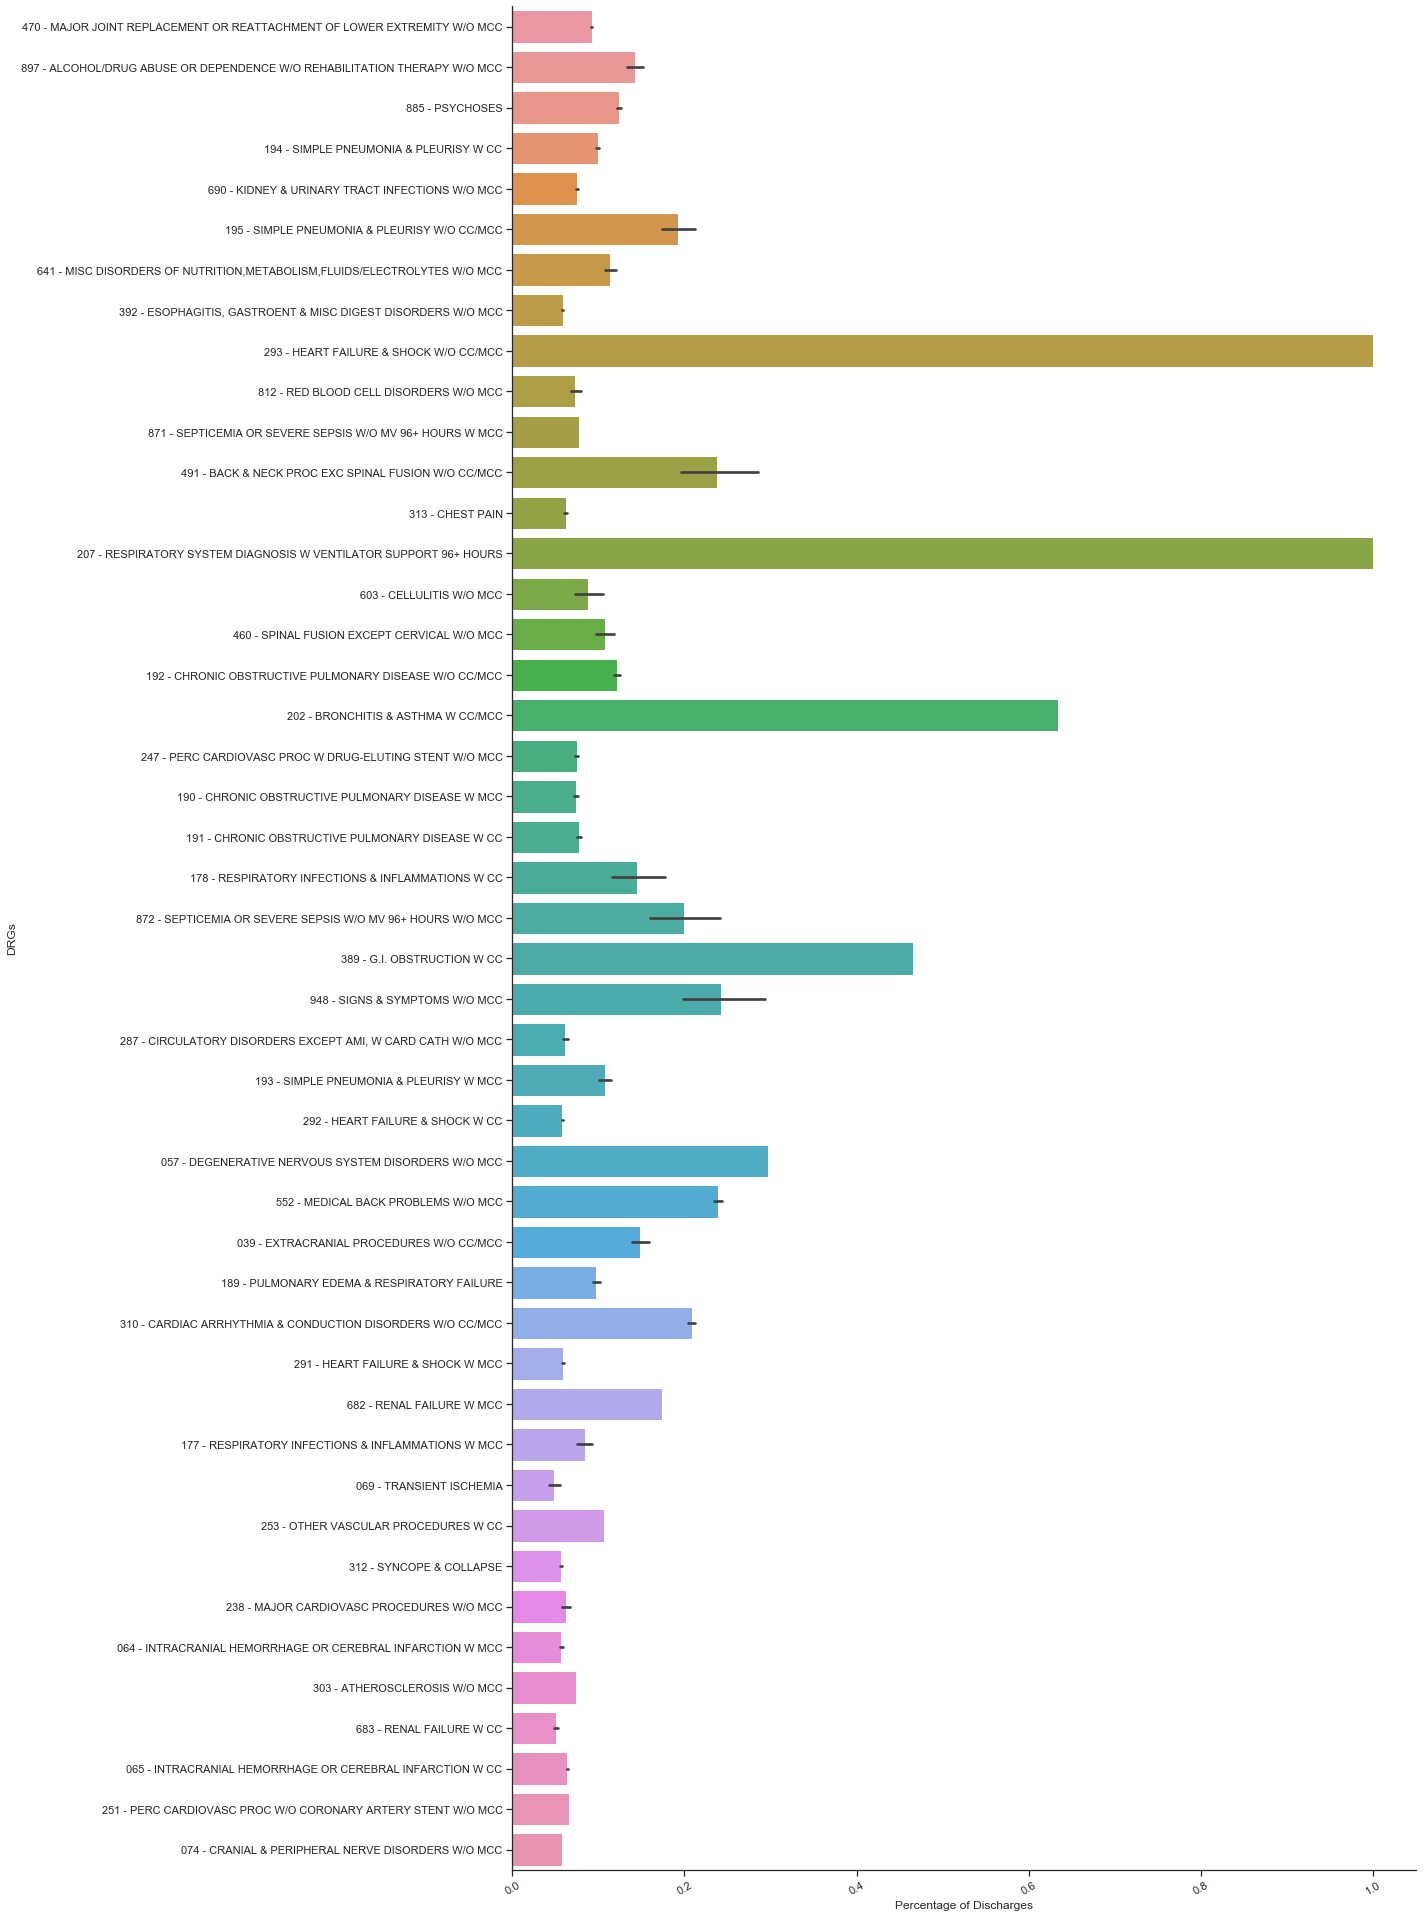

In [25]:
sns.set(style="ticks", color_codes=True)
# I tried adding the sort parameter to this, but couldn't figure out how to make it work.
graph = sns.catplot(x="Dischg_perc", y="DRG", kind="bar", data=hosp_df) 
graph.fig.set_size_inches(15,30)
graph.set(xlabel='Percentage of Discharges', ylabel='DRGs')
graph.set_xticklabels(rotation=30)

# 3. Calculate the average Medicare payments per DRG per facility.

Check the types of each column.

In [26]:
df.dtypes

DRG                     object
Prov_Id                  int64
Prov_Name               object
Prov_Address            object
Prov_City               object
Prov_State              object
Prov_Zip                 int64
Hospital_Region         object
Reg_Total_Discharges     int64
Reg_Avg_Covered_Chgs    object
Reg_Avg_Total_Pmts      object
Avg_Medicare_Pmts       object
dtype: object

Drop the $ from the average medicare payments field and then convert it to a float.

In [27]:
df['Avg_Medicare_Pmts'] = df['Avg_Medicare_Pmts'].str \
                                                 .replace('$', '') \
                                                 .astype(float)
df['Avg_Medicare_Pmts'].head()

0               4,763.73
1               4,976.71
2               4,453.79
3               4,129.16
4               4,851.44
Name: Avg_Medicare_Pmts, dtype: float64

Now group the rows by provider name and the DRG and then print the average of the Avg_Medicare_Pmts.

In [28]:
pd.DataFrame(df.groupby(['Prov_Name', 'DRG'])['Avg_Medicare_Pmts'].mean())

Avg_Medicare_Pmts
Prov_Name                                     DRG                                                                    
ABBEVILLE GENERAL HOSPITAL                    178 - RESPIRATORY INFECTIONS & INFLAMMATIONS W CC              8,071.08
                                              192 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W/O...             4,318.73
                                              194 - SIMPLE PNEUMONIA & PLEURISY W CC                         5,298.79
                                              195 - SIMPLE PNEUMONIA & PLEURISY W/O CC/MCC                   3,534.56
                                              202 - BRONCHITIS & ASTHMA W CC/MCC                             4,766.37
                                              291 - HEART FAILURE & SHOCK W MCC                             10,678.55
                                              292 - HEART FAILURE & SHOCK W CC                               6,097.47
                                              293 - HEART FAILURE & SHOCK W/O CC/MCC                         3,381.50
                                              392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DISO...             3,375.27
                                              470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT O...            12,148.00
                                              603 - CELLULITIS W/O MCC                                       4,099.24
                                              641 - MISC DISORDERS OF NUTRITION,METABOLISM,FL...             3,449.71
                                              682 - RENAL FAILURE W MCC                                      9,694.41
                                              683 - RENAL FAILURE W CC                                       6,615.35
                                              689 - KIDNEY & URINARY TRACT INFECTIONS W MCC                  6,390.35
                                              690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC                4,017.78
                                              812 - RED BLOOD CELL DISORDERS W/O MCC                         4,372.63
                                              872 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HO...             6,545.83
ABBOTT NORTHWESTERN HOSPITAL                  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC                       5,427.45
                                              057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/O...             5,199.93
                                              064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFAR...            11,728.16
                                              065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFAR...             6,537.17
                                              066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFAR...             4,326.11
                                              069 - TRANSIENT ISCHEMIA                                       3,837.11
                                              074 - CRANIAL & PERIPHERAL NERVE DISORDERS W/O MCC             5,003.21
                                              101 - SEIZURES W/O MCC                                         4,285.67
                                              149 - DYSEQUILIBRIUM                                           2,987.95
                                              176 - PULMONARY EMBOLISM W/O MCC                               6,057.50
                                              177 - RESPIRATORY INFECTIONS & INFLAMMATIONS W MCC            12,086.04
                                              178 - RESPIRATORY INFECTIONS & INFLAMMATIONS W CC              8,595.44
                                              189 - PULMONARY EDEMA & RESPIRATORY FAILURE                    7,693.22
                                              190 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W MCC              7,623.24
                                              191 - CHRONIC OBSTRUCTIVE PULMONARY DISEAS

# 4. Is there a way to group facilities in a logical way?

Grouping the facilities by their top DRG gives insight into what hospitals primarily treat the same DRGs. Each group could then coordinate to find best practices for each DRG and then share that analysis with all of the other hospitals who have less experience treating that DRG.

In [29]:
pd.DataFrame(hosp_df.groupby(['DRG', 'Prov_Name'])['Dischg_perc'].mean())

Dischg_perc
DRG                                                Prov_Name                                                              
039 - EXTRACRANIAL PROCEDURES W/O CC/MCC           HEART HOSPITAL OF LAFAYETTE                                        0.15
                                                   KANSAS HEART HOSPITAL                                              0.23
                                                   LOUISIANA MEDICAL CENTER AND HEART HOSPITAL, LLC                   0.10
                                                   THE HEART HOSPITAL BAYLOR PLANO                                    0.12
057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/O... UNITY MEDICAL AND SURGICAL HOSPITAL                                0.30
064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFAR... CAPITAL HEALTH SYSTEM-FULD CAMPUS                                  0.08
                                                   MEMORIAL HERMANN TEXAS MEDICAL CENTER                              0.05
                                                   ST LOUIS UNIVERSITY HOSPITAL                                       0.05
065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFAR... ERLANGER MEDICAL CENTER                                            0.06
                                                   SWEDISH MEDICAL CENTER/CHERRY HILL                                 0.07
069 - TRANSIENT ISCHEMIA                           FAXTON-ST LUKE'S HEALTHCARE                                        0.04
                                                   GEORGIANA HOSPITAL                                                 0.13
074 - CRANIAL & PERIPHERAL NERVE DISORDERS W/O MCC HAHNEMANN UNIVERSITY HOSPITAL                                      0.06
177 - RESPIRATORY INFECTIONS & INFLAMMATIONS W MCC CHINO VALLEY MEDICAL CENTER                                        0.14
                                                   INDIANA REGIONAL MEDICAL CENTER                                    0.05
178 - RESPIRATORY INFECTIONS & INFLAMMATIONS W CC  COFFEYVILLE REGIONAL MEDICAL CENTER                                0.08
                                                   HEBREW HOME AND HOSPITAL INC                                       0.30
                                                   LAGUNA HONDA HOSPITAL & REHABILITATION CENTER                      0.50
                                                   MORTON COUNTY HOSPITAL                                             0.22
189 - PULMONARY EDEMA & RESPIRATORY FAILURE        BROWN COUNTY GENERAL HOSPITAL                                      0.19
                                                   CARSON CITY HOSPITAL                                               0.14
                                                   CHILTON MEDICAL CENTER                                             0.17
                                                   COMMUNITY AND MISSION  HOSPITAL OF HUNTINGTON PARK                 0.11
                                                   INDIANA UNIVERSITY HEALTH ARNETT HOSPITAL                          0.06
                                                   MEDWEST HARRIS                                                     0.15
                                                   NICHOLAS H NOYES MEMORIAL HOSPITAL                                 0.10
                                                   PALM BAY HOSPITAL                                                  0.13
                                                   PATTIE A CLAY REGIONAL MEDICAL CENTER                              0.15
                                                   ROCKVILLE GENERAL HOSPITAL                                         0.09
                                                   SPALDING REGIONAL MEDICAL CENTER                                   0.04
                                                   TANNER MEDICAL CENTER VILLA RICA                                   0.23
                                                   T

## But let's try using a cluster model to group the hospitals. 

### We'll work with hosp_df first.

In [30]:
hosp_df.head(2)

Prov_Name          Dischg_perc  \
113975  MIDWEST ORTHOPEDIC SPECIALTY HOSPITAL, LLC                 1.00   
113194           MEDICAL CENTER AT ELIZABETH PLACE                 1.00   

                                                      DRG  
113975  470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...  
113194  470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...

In [31]:
hosp_df.Prov_Name.count()

163065

Splice the first three characters off the DRG code (just the numeric portion of the code) and convert it to an interger.

In [34]:
hosp_df["DRG_code"] = hosp_df['DRG'].str[:3].astype(int)
hosp_df.head()

Prov_Name          Dischg_perc  \
113975     MIDWEST ORTHOPEDIC SPECIALTY HOSPITAL, LLC                 1.00   
113194              MEDICAL CENTER AT ELIZABETH PLACE                 1.00   
112160                 PHYSICIANS' MEDICAL CENTER LLC                 1.00   
112849  CHRISTUS ST VINCENT PHYSICIANS MEDICAL CENTER                 1.00   
113729               SUGAR LAND SURGICAL HOSPITAL LLP                 1.00   

                                                      DRG  DRG_code  
113975  470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...       470  
113194  470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...       470  
112160  470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...       470  
112849  470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...       470  
113729  470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...       470

Drop the string columns before fitting the remaining data to a model.
- Create it.
- Fit it.
- Use (predict) it.

In [35]:
# Drop the string columns for clustering.
hosp_codes_df = hosp_df.drop(columns = ['Prov_Name', 'DRG'])

# Now work with only the numerical data.
kmeans = KMeans(n_clusters=5)
kmeans.fit(hosp_codes_df)

kmeans.predict(hosp_codes_df)

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

The afore created kmeans model was created using the following features:
- Dischg_perc and
- DRG_code.

Now use the afore created kmeans model to now predict the clusters for each hospital in 2-dimensions.

Text(0.5, 1.0, 'DRG_code and Hospital Code By Cluster')

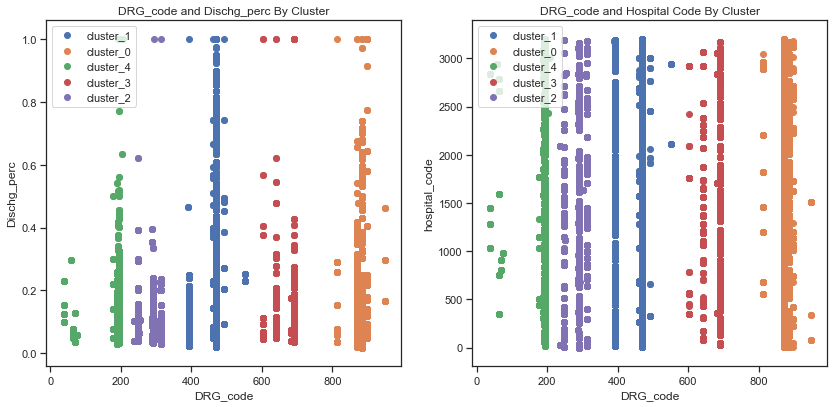

In [38]:
hosp_df['cluster'] = kmeans.predict(hosp_codes_df)

hosp_df.cluster = 'cluster_' + hosp_df.cluster.astype('str')

plt.figure(figsize=(14, 14))

plt.subplot(221)

for hospital in hosp_df.cluster.unique():
    plot_df = hosp_df[hosp_df.cluster == hospital]
    plt.scatter(plot_df.DRG_code, plot_df.Dischg_perc, label=hospital)

plt.legend()
plt.xlabel('DRG_code')
plt.ylabel('Dischg_perc')
plt.title('DRG_code and Dischg_perc By Cluster')

# encode the Provider Names so that they can be plotted.
lb_make = LabelEncoder()
hosp_df["hospital_code"] = lb_make.fit_transform(hosp_df["Prov_Name"])

plt.subplot(222)

for hospital in hosp_df.cluster.unique():
    plot_df = hosp_df[hosp_df.cluster == hospital]
    plt.scatter(plot_df.DRG_code, plot_df.hospital_code, label=hospital)

plt.legend()
plt.xlabel('DRG_code')
plt.ylabel('hospital_code')
plt.title('DRG_code and Hospital Code By Cluster')

What are the cluster centers for each feature for each cluster?

In [39]:
pd.DataFrame(kmeans.cluster_centers_, columns= hosp_codes_df.columns)\
    .reset_index()\
    .rename({'index': 'cluster'}, axis=1)\
    .set_index('cluster')

Dischg_perc             DRG_code
cluster                                          
0                       0.09               873.81
1                       0.09               459.74
2                       0.06               284.91
3                       0.08               681.10
4                       0.10               185.48

Print a chart listing the DRGs by cluster and also print the hospital names and discharge percentages.

In [40]:
pd.DataFrame(hosp_df.groupby(['cluster','DRG', 'Prov_Name'])['Dischg_perc'].mean())

Dischg_perc
cluster   DRG                                                Prov_Name                                                              
cluster_0 812 - RED BLOOD CELL DISORDERS W/O MCC             COOPER UNIVERSITY HOSPITAL                                         0.03
                                                             E A CONWAY MEDICAL CENTER                                          0.29
                                                             JACKSON MEDICAL CENTER                                             0.26
                                                             LSU HEALTH SCIENCES CENTER - SHREVEPORT                            0.06
                                                             NATCHEZ COMMUNITY HOSPITAL/SWING BED                               0.07
                                                             REGIONAL MEDICAL CENTER AT MEMPHIS                                 0.15
                                                             TRUMAN MEDICAL CENTER HOSPITAL HILL                                0.07
                                                             TULANE MEDICAL CENTER                                              0.06
                                                             TUOMEY HEALTHCARE SYSTEM                                           0.06
                                                             UNIV OF SOUTH ALABAMA MEDICAL CENTER                               0.15
                                                             UNIVERSITY OF ILLINOIS HOSPITAL                                    0.08
                                                             W O MOSS REGIONAL MEDICAL CENTER                                   1.00
          871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HO... ADIRONDACK MEDICAL CENTER                                          0.19
                                                             ADVENTIST BOLINGBROOK HOSPITAL                                     0.10
                                                             ADVENTIST LA GRANGE MEMORIAL HOSPITAL                              0.06
                                                             ADVOCATE GOOD SHEPHERD HOSPITAL                                    0.05
                                                             ADVOCATE SOUTH SUBURBAN HOSPITAL                                   0.04
                                                             AKRON GENERAL MEDICAL CENTER                                       0.06
                                                             ALAMANCE REGIONAL MEDICAL CENTER                                   0.06
                                                             ALAMEDA HOSPITAL                                                   0.12
                                                             ALBEMARLE HOSPITAL AUTHORITY                                       0.05
                                                             ALHAMBRA HOSPITAL MEDICAL CENTER                                   0.23
                                                             ALLE KISKI MEDICAL CENTER                                          0.07
                                                             ALLEGIANCE HEALTH                                                  0.09
                                                             ALTA BATES SUMMIT MEDICAL CENTER                                   0.06
                                                             ALTA BATES SUMMIT MEDICAL CENTER - ALTA BATES CAMP                 0.06
                                                             ALTON MEMORIAL HOSPITAL                                            0.11
                                                             ALTOONA REGIONAL HEALTH SYSTEM                                     0.05
                                                             ALVARADO HOSPITAL MEDICAL CENTER                                   0.1

### Now let's try it using df to use ALL of the numeric fields to cluster and all of the hospitals. We'll use the original df rather than hosp_df which is a subset of the data.

In [41]:
df.Prov_Name.count()

163065

Convert the DRG code to an integer by dropping the label and casting to int.

In [42]:
df["DRG_code"] = df['DRG'].str[:3].astype(int)
df.head(2)

DRG  Prov_Id  \
0  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    10001   
1  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    10005   

                          Prov_Name                Prov_Address Prov_City  \
0  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE    DOTHAN   
1     MARSHALL MEDICAL CENTER SOUTH  2505 U S HIGHWAY 431 NORTH      BOAZ   

  Prov_State  Prov_Zip  Hospital_Region  Reg_Total_Discharges  \
0         AL     36301      AL - Dothan                    91   
1         AL     35957  AL - Birmingham                    14   

  Reg_Avg_Covered_Chgs Reg_Avg_Total_Pmts    Avg_Medicare_Pmts  DRG_code  
0            $32963.07           $5777.24             4,763.73        39  
1            $15131.85           $5787.57             4,976.71        39

Print info about the features including type.

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 13 columns):
DRG                     163065 non-null object
Prov_Id                 163065 non-null int64
Prov_Name               163065 non-null object
Prov_Address            163065 non-null object
Prov_City               163065 non-null object
Prov_State              163065 non-null object
Prov_Zip                163065 non-null int64
Hospital_Region         163065 non-null object
Reg_Total_Discharges    163065 non-null int64
Reg_Avg_Covered_Chgs    163065 non-null object
Reg_Avg_Total_Pmts      163065 non-null object
Avg_Medicare_Pmts       163065 non-null float64
DRG_code                163065 non-null int64
dtypes: float64(1), int64(4), object(8)
memory usage: 16.2+ MB


Drop the features that are object types and drop Prov_Id.

In [59]:
codes_df = df.drop(columns = ['DRG', 'Prov_Id', 'Prov_Name', 'Prov_Address', 'Prov_City', 
                              'Prov_State'])

In [60]:
lb_make = preprocessing.LabelEncoder()
codes_df['Hospital_Region'] = lb_make.fit_transform(codes_df['Hospital_Region'])

In [61]:
codes_df['Reg_Avg_Covered_Chgs'] = codes_df['Reg_Avg_Covered_Chgs'].str[1:].astype(float)
codes_df['Reg_Avg_Total_Pmts'] = codes_df['Reg_Avg_Total_Pmts'].str[1:].astype(float)
codes_df.head()

Prov_Zip  Hospital_Region  Reg_Total_Discharges  Reg_Avg_Covered_Chgs  \
0     36301                2                    91             32,963.07   
1     35957                1                    14             15,131.85   
2     35631                1                    24             37,560.37   
3     35235                1                    25             13,998.28   
4     35007                1                    18             31,633.27   

    Reg_Avg_Total_Pmts    Avg_Medicare_Pmts  DRG_code  
0             5,777.24             4,763.73        39  
1             5,787.57             4,976.71        39  
2             5,434.95             4,453.79        39  
3             5,417.56             4,129.16        39  
4             5,658.33             4,851.44        39

What's left?

In [62]:
codes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 7 columns):
Prov_Zip                163065 non-null int64
Hospital_Region         163065 non-null int64
Reg_Total_Discharges    163065 non-null int64
Reg_Avg_Covered_Chgs    163065 non-null float64
Reg_Avg_Total_Pmts      163065 non-null float64
Avg_Medicare_Pmts       163065 non-null float64
DRG_code                163065 non-null int64
dtypes: float64(3), int64(4)
memory usage: 8.7 MB


Check the correlations of these features to see if we should drop any.

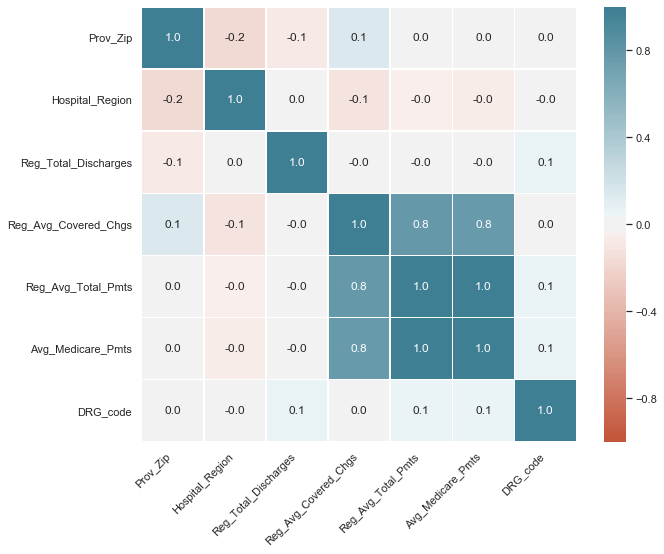

In [111]:
plt.figure(figsize=(10, 8))

corr = codes_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    linewidths=.5,
    annot=True,
    fmt='.1f'
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Looks like we should drop Avg_Medicare_Pmts and Reg_Avg_Covered_Chgs.

In [122]:
codes_df.drop(columns=['Avg_Medicare_Pmts', 'Reg_Avg_Covered_Chgs'], inplace=True)

Let's check that heatmap one more time.

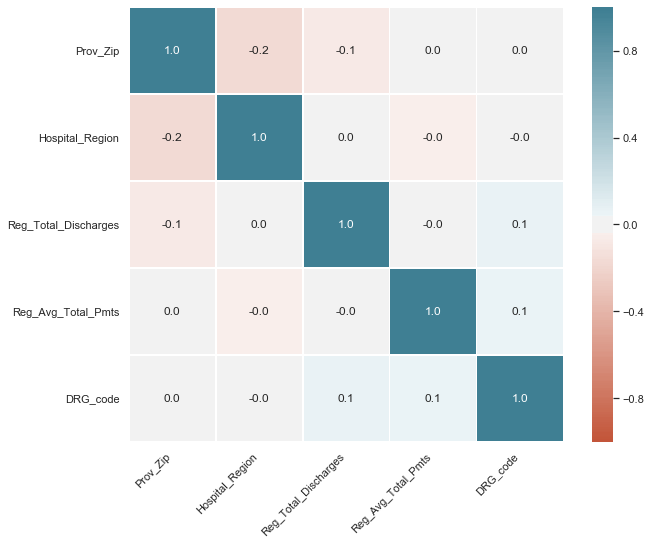

In [123]:
plt.figure(figsize=(10, 8))

corr = codes_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    linewidths=.5,
    annot=True,
    fmt='.1f'
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Correlations look good!

Now ready to model the clusters on codes_df including these features:
- Prov_Zip, 
- Hospital_Region,
- Reg_Total_Discharges, 
- Reg_Avg_Total_Pmts, and
- DRG_code.

In [124]:
# Create it.
kmeans = KMeans(n_clusters=5)
# Fit it.
kmeans.fit(codes_df)
# Use it.
kmeans.predict(codes_df)

array([3, 3, 3, ..., 1, 1, 1], dtype=int32)

Text(0.5, 1.0, 'DRG Code and Provider Zip Code By Cluster')

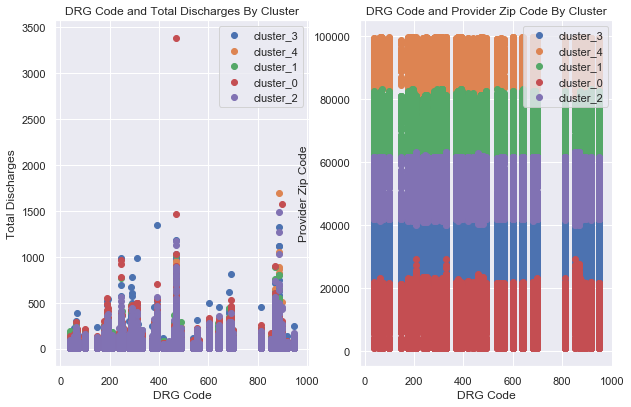

In [126]:
# Add those predictions as a column to df.
df['cluster'] = kmeans.predict(codes_df)

df.cluster = 'cluster_' + df.cluster.astype('str')

# Now let's plot the DRG_codes against the Reg_Total_Discharges in a scatter plot.
plt.figure(figsize=(10, 14))

plt.subplot(221)

for hospital in df.cluster.unique():
    plot_df = df[df.cluster == hospital]
    plt.scatter(plot_df.DRG_code, plot_df.Reg_Total_Discharges, label=hospital)

plt.legend()
plt.xlabel('DRG Code')
plt.ylabel('Total Discharges')
plt.title('DRG Code and Total Discharges By Cluster')

# And let's plot the DRG_codes against the Prov_Zip.
plt.subplot(222)

for hospital in df.cluster.unique():
    plot_df = df[df.cluster == hospital]
    plt.scatter(plot_df.DRG_code, plot_df.Prov_Zip, label=hospital)

plt.legend()
plt.xlabel('DRG Code')
plt.ylabel('Provider Zip Code')
plt.title('DRG Code and Provider Zip Code By Cluster')

What are the cluster centers for each feature in each cluster?

In [127]:
pd.DataFrame(kmeans.cluster_centers_, columns= codes_df.columns)\
    .reset_index()\
    .rename({'index': 'cluster'}, axis=1)\
    .set_index('cluster')

Prov_Zip      Hospital_Region  Reg_Total_Discharges  \
cluster                                                                   
0                  11,880.19               179.10                 46.53   
1                  72,592.72               180.00                 39.78   
2                  51,049.31               157.48                 44.21   
3                  32,268.02               138.43                 44.97   
4                  92,045.79                93.78                 35.41   

          Reg_Avg_Total_Pmts             DRG_code  
cluster                                            
0                  10,944.26               395.44  
1                   8,515.75               394.44  
2                   9,458.22               393.68  
3                   8,408.84               394.58  
4                  11,931.85               402.34

Print a list of hospitals with their encoded zip codes grouped by cluster. Recall that these clusters were created using:
- Prov_Zip,
- Hospital_Region,
- Reg_Total_Discharges,
- Reg_Avg_Total_Pmts, and
- DRG_code.

In [128]:
pd.options.display.max_rows = 4000
pd.DataFrame(df.groupby(['cluster','Prov_Name'])['Prov_Zip'].median())

Prov_Zip
cluster   Prov_Name                                                   
cluster_0 ABINGTON MEMORIAL HOSPITAL                             19001
          ACMH HOSPITAL                                          16201
          ADCARE HOSPITAL OF WORCESTER INC                        1605
          ADIRONDACK MEDICAL CENTER                              12983
          ADVANCED SURGICAL HOSPITAL                             15301
          ALBANY MEDICAL CENTER HOSPITAL                         12208
          ALBANY MEMORIAL HOSPITAL                               12204
          ALBERT EINSTEIN MEDICAL CENTER                         19141
          ALICE HYDE MEDICAL CENTER                              12953
          ALLE KISKI MEDICAL CENTER                              15065
          ALLEGHENY GENERAL HOSPITAL                             15212
          ALTOONA REGIONAL HEALTH SYSTEM                         16601
          ANNA JAQUES HOSPITAL                                    1950
          ANNE ARUNDEL MEDICAL CENTER                            21401
          ARIA HEALTH                                            19114
          ARNOT OGDEN MEDICAL CENTER                             14905
          AROOSTOOK MEDICAL CENTER,THE                            4769
          ATLANTIC GENERAL HOSPITAL                              21811
          ATLANTICARE REGIONAL MEDICAL CENTER - CITY DIV          8401
          AUBURN COMMUNITY HOSPITAL                              13021
          AUGUSTA HEALTH                                         22939
          AURELIA OSBORN FOX MEMORIAL HOSPITAL                   13820
          BALTIMORE WASHINGTON  MEDICAL CENTER                   21061
          BAYHEALTH - KENT GENERAL HOSPITAL                      19901
          BAYHEALTH - MILFORD MEMORIAL HOSPITAL                  19963
          BAYONNE HOSPITAL CENTER                                 7002
          BAYSHORE COMMUNITY HOSPITAL                             7733
          BAYSTATE FRANKLIN MEDICAL CENTER                        1301
          BAYSTATE MARY LANE HOSPITAL                             1082
          BAYSTATE MEDICAL CENTER                                 1199
          BEEBE MEDICAL CENTER                                   19958
          BELLEVUE HOSPITAL CENTER                               10016
          BENEDICTINE HOSPITAL                                   12401
          BERGEN REGIONAL MEDICAL CENTER                          7652
          BERKSHIRE MEDICAL CENTER INC                            1201
          BERTRAND CHAFFEE HOSPITAL                              14141
          BERWICK HOSPITAL CENTER                                18603
          BETH ISRAEL DEACONESS HOSPITAL - NEEDHAM                2494
          BETH ISRAEL DEACONESS MEDICAL CENTER                    2215
          BETH ISRAEL MEDICAL CENTER                             10003
          BEVERLY HOSPITAL CORPORATION                            1915
          BLOOMSBURG HOSPITAL                                    17815
          BON SECOURS - DEPAUL MEDICAL CENTER                    23505
          BON SECOURS - MEMORIAL REGIONAL MEDICAL                23116
          BON SECOURS - ST FRANCIS MEDICAL CENTER                23114
          BON SECOURS - ST MARYS HOSPITAL OF RICHMOND            23226
          BON SECOURS COMMUNITY HOSPITAL                         12771
          BON SECOURS HOSPITAL                                   21223
          BON SECOURS MARYVIEW MEDICAL CENTER                    23707
          BOSTON MEDICAL CENTER CORPORATION                       2118
          BRADFORD REGIONAL MEDICAL CENTER                       16701
          BRANDYWINE HOSPITAL                                    19320
          BRATTLEBORO MEMORIAL HOSPITAL                           5301
          BRIDGEPORT HOSPITAL                                     6610
          BRIGHAM AND WOMEN'S HOSPITAL                            2115
          BRIST

### A more complicated clustering method.

Let's use codes_df again.

In [131]:
codes_df.head(2)

Prov_Zip  Hospital_Region  Reg_Total_Discharges   Reg_Avg_Total_Pmts  \
0     36301                2                    91             5,777.24   
1     35957                1                    14             5,787.57   

   DRG_code  
0        39  
1        39

In [132]:
best = codes_df.copy()

Let's peek at .info to ensure the data is all ready.

In [133]:
best.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 5 columns):
Prov_Zip                163065 non-null int64
Hospital_Region         163065 non-null int64
Reg_Total_Discharges    163065 non-null int64
Reg_Avg_Total_Pmts      163065 non-null float64
DRG_code                163065 non-null int64
dtypes: float64(1), int64(4)
memory usage: 6.2 MB


Scale the data so it will model better.

In [134]:
scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(best)
best_scaled = pd.DataFrame(data=scaled_array, columns=best.columns)
best_scaled.head()

Prov_Zip      Hospital_Region  Reg_Total_Discharges  \
0                 0.36                 0.01                  0.02   
1                 0.35                 0.00                  0.00   
2                 0.35                 0.00                  0.00   
3                 0.35                 0.00                  0.00   
4                 0.34                 0.00                  0.00   

    Reg_Avg_Total_Pmts             DRG_code  
0                 0.02                 0.00  
1                 0.02                 0.00  
2                 0.02                 0.00  
3                 0.02                 0.00  
4                 0.02                 0.00

Now create and fit a model to plot the elbow graph to decide how many clusters we should use.

   k                  sse
0  1            37,475.15
1  2            26,637.29
2  3            20,541.03
3  4            15,956.33
4  5            12,412.11
5  6            10,788.73
6  7             9,343.99
7  8             8,210.60
8  9             7,441.34


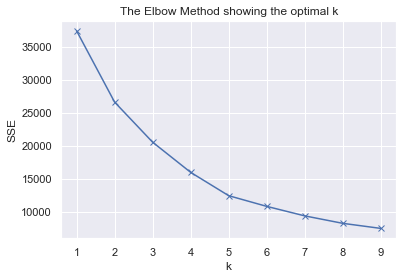

In [135]:
best_df = best_scaled.copy() # could drop some columns 

ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(best_df)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Print the values for the elbow data.

In [136]:
elbow = pd.DataFrame(dict(k=ks, sse=sse))
elbow

k                  sse
0  1            37,475.15
1  2            26,637.29
2  3            20,541.03
3  4            15,956.33
4  5            12,412.11
5  6            10,788.73
6  7             9,343.99
7  8             8,210.60
8  9             7,441.34

Calculate how much difference is between each value for k to decide where the gain drops off.

In [137]:
elbow['diff'] = pd.Series()
for i in range(8):
    elbow['diff'][i] = elbow['sse'][i] - elbow['sse'][i+1]

elbow['diff1'] = pd.Series()
for i in range(8):
    elbow['diff1'][i] = elbow['diff'][i] - elbow['diff'][i+1]
elbow

k                  sse                 diff                diff1
0  1            37,475.15            10,837.86             4,741.59
1  2            26,637.29             6,096.26             1,511.57
2  3            20,541.03             4,584.70             1,040.47
3  4            15,956.33             3,544.22             1,920.85
4  5            12,412.11             1,623.38               178.63
5  6            10,788.73             1,444.75               311.36
6  7             9,343.99             1,133.39               364.13
7  8             8,210.60               769.26                  nan
8  9             7,441.34                  nan                  nan

So I will choose k=4, four clusters.

In [138]:
best_df.head(1)

Prov_Zip      Hospital_Region  Reg_Total_Discharges  \
0                 0.36                 0.01                  0.02   

    Reg_Avg_Total_Pmts             DRG_code  
0                 0.02                 0.00

Run the cluster algorithm to assign cluster ids to each entry.

In [ ]:
title = '4 Clusters'
kmeans = KMeans(n_clusters=4)

# fit the kmeans object
kmeans.fit(best_df)

Visualize the clusters on a three-dimensional graph using three of the features used to create the clusters.

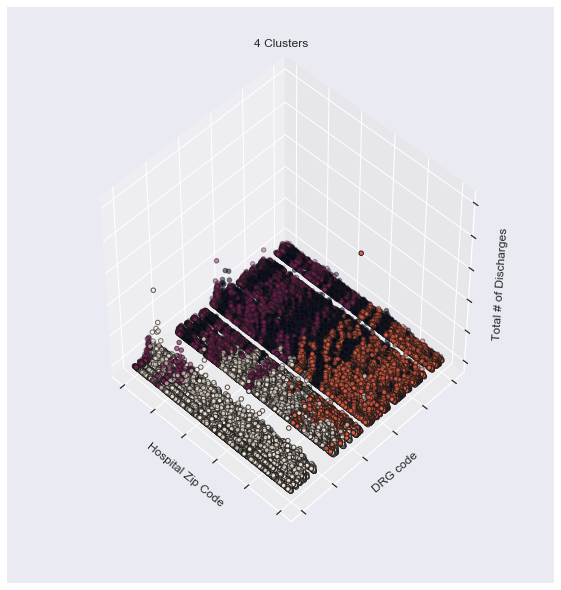

In [148]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
labels = kmeans.labels_

ax.scatter(best_df.Prov_Zip, 
           best_df.DRG_code, 
           best_df.Reg_Total_Discharges,
           c=labels.astype(np.float), edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Hospital Zip Code')
ax.set_ylabel('DRG code')
ax.set_zlabel('Total # of Discharges')
ax.set_title(title)
ax.dist = 12

Let's try some different features to see which three features best show the clusters.

In [140]:
best_df.head(1)

Prov_Zip      Hospital_Region  Reg_Total_Discharges  \
0                 0.36                 0.01                  0.02   

    Reg_Avg_Total_Pmts             DRG_code  
0                 0.02                 0.00

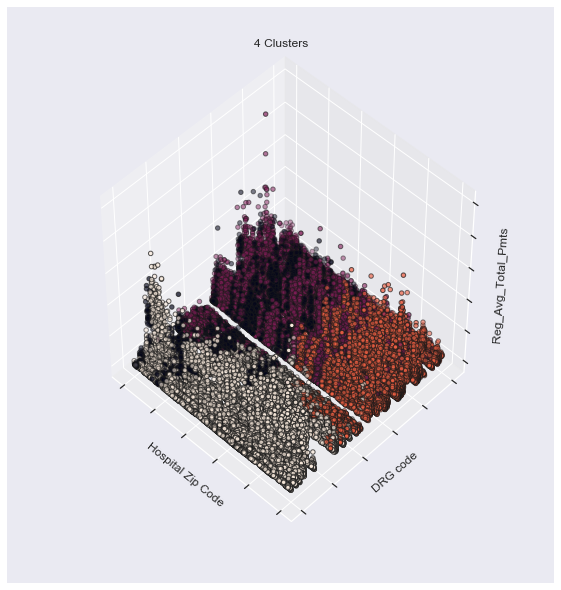

In [142]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
labels = kmeans.labels_

ax.scatter(best_df.Prov_Zip, 
           best_df.DRG_code, 
           best_df.Reg_Avg_Total_Pmts,
           c=labels.astype(np.float), edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Hospital Zip Code')
ax.set_ylabel('DRG code')
ax.set_zlabel('Reg_Avg_Total_Pmts')
ax.set_title(title)
ax.dist = 12

In [143]:
best_df.head(1)

Prov_Zip      Hospital_Region  Reg_Total_Discharges  \
0                 0.36                 0.01                  0.02   

    Reg_Avg_Total_Pmts             DRG_code  
0                 0.02                 0.00

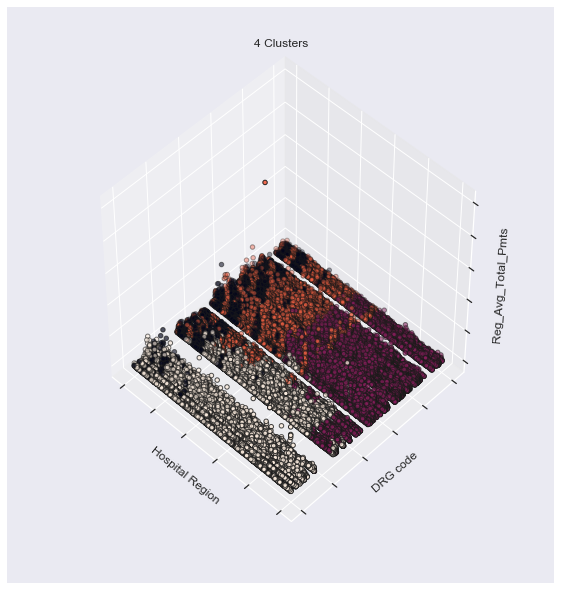

In [144]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
labels = kmeans.labels_

ax.scatter(best_df.Hospital_Region, 
           best_df.DRG_code, 
           best_df.Reg_Total_Discharges,
           c=labels.astype(np.float), edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Hospital Region')
ax.set_ylabel('DRG code')
ax.set_zlabel('Reg_Avg_Total_Pmts')
ax.set_title(title)
ax.dist = 12

In [145]:
best_df.head(1)

Prov_Zip      Hospital_Region  Reg_Total_Discharges  \
0                 0.36                 0.01                  0.02   

    Reg_Avg_Total_Pmts             DRG_code  
0                 0.02                 0.00

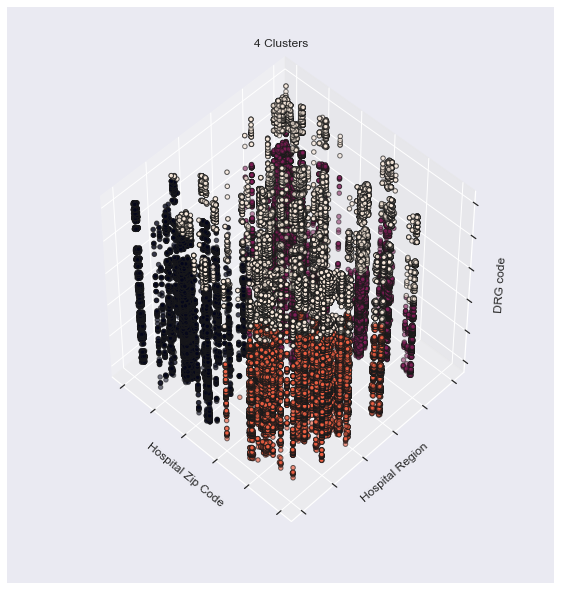

In [146]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
labels = kmeans.labels_

ax.scatter(best_df.Prov_Zip,
           best_df.Hospital_Region,
           best_df.DRG_code,
           c=labels.astype(np.float), edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Hospital Zip Code')
ax.set_ylabel('Hospital Region')
ax.set_zlabel('DRG code')
ax.set_title(title)
ax.dist = 12

This last combination certainly spread out the clusters best.

What are the centers of the clusters for each feature?

In [150]:
best_cluster = pd.DataFrame(kmeans.cluster_centers_, columns= best_df.columns)\
    .reset_index()\
    .rename({'index': 'cluster'}, axis=1)\
    .set_index('cluster')
best_cluster

Prov_Zip      Hospital_Region  Reg_Total_Discharges  \
cluster                                                                   
0                       0.58                 0.24                  0.01   
1                       0.78                 0.84                  0.01   
2                       0.21                 0.69                  0.01   
3                       0.40                 0.46                  0.01   

          Reg_Avg_Total_Pmts             DRG_code  
cluster                                            
0                       0.05                 0.28  
1                       0.04                 0.36  
2                       0.05                 0.28  
3                       0.05                 0.79

Put the predictions for the cluster for each hospital into a new column in best_df.

In [155]:
# Add predictions as a column to df.
best_df['cluster'] = kmeans.predict(best_df)

best_df.cluster = 'cluster_' + best_df.cluster.astype('str')

Print a list of hospitals with their encoded zip codes grouped by cluster. Recall that these clusters were created using:

- Prov_Zip,
- Hospital_Region,
- Reg_Total_Discharges,
- Reg_Avg_Total_Pmts, and
- DRG_code.

In [156]:
best_df.head(1)

Prov_Zip      Hospital_Region  Reg_Total_Discharges  \
0                 0.36                 0.01                  0.02   

    Reg_Avg_Total_Pmts             DRG_code    cluster  
0                 0.02                 0.00  cluster_0

In [157]:
pd.options.display.max_rows = 4000
pd.DataFrame(best_df.groupby(['cluster','Hospital_Region'])['Prov_Zip'].median())

Prov_Zip
cluster   Hospital_Region                     
cluster_0 0.00                            1.00
          0.00                            0.35
          0.01                            0.36
          0.01                            0.35
          0.01                            0.36
          0.02                            0.35
          0.02                            0.35
          0.02                            0.73
          0.03                            0.72
          0.03                            0.72
          0.03                            0.73
          0.04                            0.75
          0.04                            0.85
          0.04                            0.85
          0.05                            0.85
          0.05                            0.86
          0.05                            0.95
          0.06                            0.93
          0.06                            0.96
          0.06                            0.95
          0.07                            0.94
          0.07                            0.91
          0.07                            0.95
          0.08                            0.95
          0.08                            0.93
          0.08                            0.92
          0.09                            0.96
          0.09                            0.96
          0.09                            0.94
          0.10                            0.92
          0.10                            0.92
          0.10                            0.94
          0.10                            0.95
          0.11                            0.94
          0.11                            0.94
          0.11                            0.93
          0.12                            0.95
          0.12                            0.96
          0.12                            0.95
          0.13                            0.93
          0.13                            0.80
          0.13                            0.81
          0.14                            0.80
          0.14                            0.82
          0.14                            0.81
          0.15                            0.81
          0.15                            0.81
          0.15                            0.06
          0.16                            0.05
          0.16                            0.06
          0.16                            0.20
          0.17                            0.19
          0.17                            0.34
          0.17                            0.34
          0.18                            0.33
          0.18                            0.33
          0.18                            0.32
          0.19                            0.34
          0.19                            0.32
          0.19                            0.33
          0.20                            0.32
          0.20                            0.34
          0.20                            0.32
          0.21                            0.31
          0.21                            0.32
          0.21                            0.32
          0.22                            0.34
          0.22                            0.33
          0.22                            0.31
          0.23                            0.33
          0.23                            0.31
          0.23                            0.30
          0.24                            0.30
          0.24                            0.31
          0.24                            0.30
          0.25                            0.29
          0.25                            0.31
          0.25                            0.97
          0.26                            0.52
          0.26                            0.52
          0.26                            0.50
          0.27                            0.52
          0.27                            0.52
          0.27                            0

# I need to confirm that the following is assigning the provider names to the right rows.

Add the Provider Names to the dataframe which is still in the same order.

In [158]:
best_df['Prov_Name'] = df['Prov_Name']

Now let's look at what we have.

In [159]:
best_df.head(2)

Prov_Zip      Hospital_Region  Reg_Total_Discharges  \
0                 0.36                 0.01                  0.02   
1                 0.35                 0.00                  0.00   

    Reg_Avg_Total_Pmts             DRG_code    cluster  \
0                 0.02                 0.00  cluster_0   
1                 0.02                 0.00  cluster_0   

                          Prov_Name  
0  SOUTHEAST ALABAMA MEDICAL CENTER  
1     MARSHALL MEDICAL CENTER SOUTH

Print the hospitals by cluster.

In [160]:
pd.options.display.max_rows = 4000
pd.DataFrame(best_df.groupby(['cluster', 'Prov_Name'])['Prov_Zip'].median())

Prov_Zip
cluster   Prov_Name                                                              
cluster_0 ABBEVILLE GENERAL HOSPITAL                                         0.70
          ABBOTT NORTHWESTERN HOSPITAL                                       0.55
          ADVENTIST BOLINGBROOK HOSPITAL                                     0.60
          ADVENTIST GLENOAKS                                                 0.60
          ADVENTIST LA GRANGE MEMORIAL HOSPITAL                              0.60
          ADVENTIST MEDICAL CENTER                                           0.93
          ADVENTIST MEDICAL CENTER - REEDLEY                                 0.94
          ADVOCATE CHRIST HOSPITAL & MEDICAL CENTER                          0.60
          ADVOCATE GOOD SAMARITAN HOSPITAL                                   0.60
          ADVOCATE GOOD SHEPHERD HOSPITAL                                    0.60
          ADVOCATE ILLINOIS MASONIC MEDICAL CENTER                           0.60
          ADVOCATE LUTHERAN GENERAL HOSPITAL                                 0.60
          ADVOCATE SOUTH SUBURBAN HOSPITAL                                   0.60
          ADVOCATE TRINITY HOSPITAL                                          0.60
          AHMC ANAHEIM REGIONAL MEDICAL CENTER                               0.93
          AIKEN REGIONAL MEDICAL CENTER                                      0.29
          ALAMEDA COUNTY MEDICAL CENTER                                      0.95
          ALAMEDA HOSPITAL                                                   0.95
          ALASKA NATIVE MEDICAL CENTER                                       1.00
          ALASKA REGIONAL HOSPITAL                                           1.00
          ALEXIAN BROTHERS MEDICAL CENTER                                    0.60
          ALHAMBRA HOSPITAL MEDICAL CENTER                                   0.92
          ALLEGIANCE HEALTH                                                  0.49
          ALLEN MEMORIAL HOSPITAL                                            0.50
          ALPENA REGIONAL MEDICAL CENTER                                     0.49
          ALTA BATES SUMMIT MEDICAL CENTER                                   0.95
          ALTA BATES SUMMIT MEDICAL CENTER - ALTA BATES CAMP                 0.95
          ALTON MEMORIAL HOSPITAL                                            0.62
          ALTRU HOSPITAL                                                     0.58
          ALVARADO HOSPITAL MEDICAL CENTER                                   0.92
          AMERICAN LEGION HOSPITAL                                           0.70
          ANAHEIM GENERAL HOSPITAL                                           0.93
          ANDALUSIA REGIONAL HOSPITAL                                        0.36
          ANDERSON HOSPITAL                                                  0.62
          ANNE ARUNDEL MEDICAL CENTER                                        0.21
          ANTELOPE VALLEY HOSPITAL MED CENTER                                0.94
          APPLING HOSPITAL                                                   0.31
          ARIZONA ORTHOPEDIC SURGICAL HOSPITAL                               0.85
          ARIZONA REGIONAL MEDICAL CENTER                                    0.85
          ARIZONA SPINE AND JOINT HOSPITAL                                   0.85
          ARKANSAS HEART HOSPITAL                                            0.72
          ARKANSAS METHODIST MEDICAL CENTER                                  0.72
          ARKANSAS SURGICAL HOSPITAL                                         0.72
          ARKANSAS VALLEY REGIONAL MEDICAL CENTER                            0.81
          ARROWHEAD HOSPITAL                                                 0.85
          ARROWHEAD REGIONAL MEDICAL CENTER                                  0.92
          ARROYO GRANDE COMMUNITY HOSPITAL                                   0.94
          ATHENS REGIONAL MEDICAL CENTER               

How many hospitals are in each cluster?

In [161]:
pd.DataFrame(best_df.groupby(['cluster']).size())

0
cluster         
cluster_0  61302
cluster_1  24989
cluster_2  45695
cluster_3  31079